In [1]:
from google.colab import drive
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Import data from drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ee_file_path = '/content/drive/MyDrive/dataset/20250214_finger_3/linear-ee-path.npy'
bscan_image_template = '/content/drive/MyDrive/dataset/20250214_finger_3/combine_linear_scan/{}_bmode.npy'
# bscan_image_template = '/content/drive/MyDrive/dataset/2024_2025_RAUS_dataset_arc/20250118_images_9_arc/{}_bmode.png'
# cfm_image_template = '/content/drive/MyDrive/dataset/2024_2025_RAUS_dataset_arc/20250118_images_8_arc/channel_0_format_6_idx_{}_cfm.npy'

data = np.load(ee_file_path)
data[49]

array([[-0.99009388, -0.01077708, -0.13999275, -0.40589834],
       [-0.00927233,  0.99989207, -0.01139658, -0.1076409 ],
       [ 0.14010046, -0.00998562, -0.99008694,  0.21605277],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [3]:
print(data[0][:, 3][:3])
print(data[49][:, 3][:3])
print(data[99][:, 3][:3])


[-0.40584517 -0.11257325  0.21610203]
[-0.40589834 -0.1076409   0.21605277]
[-0.40595258 -0.10260789  0.2160025 ]


In [4]:
print(data[0][:, 1][:3])
print(data[49][:, 1][:3])
print(data[99][:, 1][:3])

[-0.01077708  0.99989207 -0.00998562]
[-0.01077708  0.99989207 -0.00998562]
[-0.01077708  0.99989207 -0.00998562]


In [5]:
print(data[0][:, 2][:3])
print(data[49][:, 2][:3])
print(data[99][:, 2][:3])

[-0.13999275 -0.01139658 -0.99008694]
[-0.13999275 -0.01139658 -0.99008694]
[-0.13999275 -0.01139658 -0.99008694]


In [6]:
poses = data.shape[0]
x_vectors = np.array([data[i][:, 0][:3] for i in range(poses)])  # (100, 3)
z_vectors = np.array([data[i][:, 1][:3] for i in range(poses)])  # (100, 3)
y_vectors = np.array([data[i][:, 2][:3] for i in range(poses)])  # (100, 3)
# positions = np.array([data[i][:, 3][:3] - [0, 0, 0.129] for i in range(poses)])  # (100, 3)
positions = np.array([data[i][:, 3][:3] + 0.129 * data[i][:, 2][:3] for i in range(poses)])

# Calculate the center position in 3D frame (X, Y)
X_mean = np.mean([np.max(positions[:, 0]), np.min(positions[:, 0])])
Y_mean = np.mean([np.max(positions[:, 1]), np.min(positions[:, 1])])

# Calculate the highest position in 3D frame (Z)
Z_max = np.max(positions[:, 2])

print(X_mean)
print(Y_mean)
print(Z_max)

plane_equations = []

# Generate buffer that express plane equation of each plane
for i in range(len(positions)):

    a, b, c = z_vectors[i]
    x0, y0, z0 = positions[i]
    d = a * x0 + b * y0 + c * z0

    plane_equations.append((a, b, c, d))

-0.4239850673732289
-0.10654422188248777
0.0883808106966325


In [7]:
print(positions[0])
print(positions[49])
print(positions[99])

[-0.42390424 -0.11404341  0.08838081]
[-0.4239574  -0.10911106  0.08833155]
[-0.42401165 -0.10407805  0.08828129]


In [8]:
print(z_vectors[0])
print(z_vectors[49])
print(z_vectors[99])

[-0.01077708  0.99989207 -0.00998562]
[-0.01077708  0.99989207 -0.00998562]
[-0.01077708  0.99989207 -0.00998562]


In [9]:
print(x_vectors[0])
print(y_vectors[0])
print(z_vectors[0])
print(positions[0])
print(positions[99])

[-0.99009388 -0.00927233  0.14010046]
[-0.13999275 -0.01139658 -0.99008694]
[-0.01077708  0.99989207 -0.00998562]
[-0.42390424 -0.11404341  0.08838081]
[-0.42401165 -0.10407805  0.08828129]


In [10]:
plane_images = []

# Generate plane_images by importing B-scan images
for idx in tqdm(range(len(plane_equations)), desc="Processing"):
    bscan_image_path = bscan_image_template.format(idx)
    # cfm_image_path = cfm_image_template.format(idx)

    bscan_image = np.load(bscan_image_path)
    # cfm_image = np.load(cfm_image_path)
    if (bscan_image is None) :
        raise FileNotFoundError(f"Image not found at path")

    plane_images.append(bscan_image)
    # plane_images2.append(cfm_image)

# Calculate range x, y, z range using X_mean, Y_mean, and Z_max
x_range = (X_mean - 0.012 , X_mean + 0.012)
y_range = (Y_mean - 0.012, Y_mean + 0.012)
z_range = (Z_max - 0.030, Z_max)

x = np.linspace(*x_range, 2 * (plane_images[0].shape)[1])
y = np.linspace(*y_range, 2 * poses)
z = np.linspace(*z_range, 2 * (plane_images[0].shape)[0])

len_pxl_width = (plane_images[0].shape)[1]
len_pxl_height = (plane_images[0].shape)[0]
len_mm_width = 25.0
len_mm_height = 30.0
ratio_of_width = len_mm_width / len_pxl_width / 1000  # width (m) per pixel
ratio_of_height = len_mm_height / len_pxl_height / 1000  # height (m) per pixel

Processing: 100%|██████████| 150/150 [00:47<00:00,  3.19it/s]


In [11]:
(plane_images[0].shape)[1]

223

In [12]:
import numpy as np
from tqdm import tqdm

plane_origins = positions
plane_normals = z_vectors
print(f"plane origins: {plane_origins.shape}")
print(f"plane normals: {plane_normals.shape}")

# Transpose query_points to move the x, y, z components to the last axis
query_points = np.array(np.meshgrid(x, y, z, indexing='ij')).transpose(1, 2, 3, 0)
print(f"query_points (transposed): {query_points.shape}")

# Initialize arrays to track only the top two distances and plane indices (best_val1 : Closest distance, best_val2 : Second closest distance, best_idx1 : Index of closest plane, best_idx2 : Index of second closest plane)
best_val1 = np.full(query_points.shape[:-1], np.inf, dtype=query_points.dtype)
best_idx1 = np.full(query_points.shape[:-1], -1,   dtype=int)
best_val2 = np.full(query_points.shape[:-1], np.inf, dtype=query_points.dtype)
best_idx2 = np.full(query_points.shape[:-1], -1,   dtype=int)

# Compute distances plane-by-plane
for i in tqdm(range(plane_origins.shape[0]), desc="Processing"):
    # Signed distance from plane i to all (x,y,z) in query_points
    distance_i = (
          (query_points[..., 0] - plane_origins[i, 0]) * plane_normals[i, 0]
        + (query_points[..., 1] - plane_origins[i, 1]) * plane_normals[i, 1]
        + (query_points[..., 2] - plane_origins[i, 2]) * plane_normals[i, 2]
    )
    abs_distance_i = np.abs(distance_i)

    # Check if abs_distance_i beats the current #1 best distance
    mask1 = abs_distance_i < best_val1

    # Put abs_distance into new #1 and old #1 into #2 where mask1 is True (abs_distance -> New #1, Old #1 -> New #2)
    new_best_val2 = np.where(mask1, best_val1, best_val2)
    new_best_idx2 = np.where(mask1, best_idx1, best_idx2)
    new_best_val1 = np.where(mask1, abs_distance_i, best_val1)
    new_best_idx1 = np.where(mask1, i, best_idx1)

    # Among those not improved by mask1, see if abs_distance_i beats #2
    mask2 = (~mask1) & (abs_distance_i < new_best_val2)

    # Put abs_distance into new #2
    final_best_val2 = np.where(mask2, abs_distance_i, new_best_val2)
    final_best_idx2 = np.where(mask2, i, new_best_idx2)

    # Update the best and second-best holders
    best_val1 = new_best_val1
    best_idx1 = new_best_idx1
    best_val2 = final_best_val2
    best_idx2 = final_best_idx2

# Stack the plane indices of the two closest planes:
closest_planes = np.stack((best_idx1, best_idx2), axis=0)
print("closest_planes shape:", closest_planes.shape)

print("distances1 shape:", best_val1.shape)
print("distances2 shape:", best_val2.shape)


plane origins: (150, 3)
plane normals: (150, 3)
query_points (transposed): (446, 300, 2166, 3)


Processing: 100%|██████████| 150/150 [24:05<00:00,  9.63s/it]


closest_planes shape: (2, 446, 300, 2166)
distances1 shape: (446, 300, 2166)
distances2 shape: (446, 300, 2166)


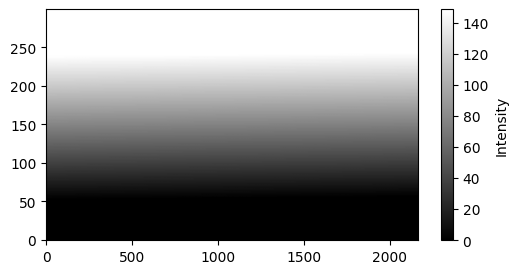

In [13]:
closest_planes_2D = best_idx1[150, :, :]

plt.figure(figsize= (2 * 3, 2 * 1.5 ))
plt.imshow(closest_planes_2D, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label="Intensity")
plt.show()

In [14]:
# Delete buffers that are not used anymore.

del best_idx1, best_idx2, new_best_val1, new_best_idx1, new_best_val2, new_best_idx2, mask1, mask2, final_best_val2, final_best_idx2, distance_i, abs_distance_i, data, positions, z_vectors

import gc
gc.collect()

5369

In [15]:
import numpy as np

# Cast plane indices to int16 (Memory Capacity)
first_closest_plane_indices = closest_planes[0, ...].astype(np.int16)
second_closest_plane_indices = closest_planes[1, ...].astype(np.int16)

print(f"first_closest_plane_indices: {first_closest_plane_indices.shape}, dtype={first_closest_plane_indices.dtype}")
print(f"second_closest_plane_indices: {second_closest_plane_indices.shape}, dtype={second_closest_plane_indices.dtype}")

# Cast positions / x_vectors / y_vectors to float16 if not already (Memory Capacity)
positions = plane_origins.astype(np.float32)
x_vectors = x_vectors.astype(np.float32)
y_vectors = y_vectors.astype(np.float32)
query_points = query_points.astype(np.float32)

# Extract origins,x_vectors, y_vectors of the closest planes for all grid points (Memory Capacity)
origins1 = positions[first_closest_plane_indices].astype(np.float32)
x_vectors1 = x_vectors[first_closest_plane_indices].astype(np.float32)
y_vectors1 = y_vectors[first_closest_plane_indices].astype(np.float32)

print(f"origins1: {origins1.shape}, dtype={origins1.dtype}")
print(f"x_vectors1: {x_vectors1.shape}, dtype={x_vectors1.dtype}")
print(f"y_vectors1: {y_vectors1.shape}, dtype={y_vectors1.dtype}")

# Extract origins,x_vectors, y_vectors of the second closest planes for all grid points (Memory Capacity)
origins2 = positions[second_closest_plane_indices].astype(np.float32)
x_vectors2 = x_vectors[second_closest_plane_indices].astype(np.float32)
y_vectors2 = y_vectors[second_closest_plane_indices].astype(np.float32)

# Calculate vector `v` from the origin to the query point
v1 = (query_points - origins1).astype(np.float32)  # shape (A,B,C,3)
v2 = (query_points - origins2).astype(np.float32)  # shape (A,B,C,3)

print(f"v1: {v1.shape}, dtype={v1.dtype}")
print(f"v2: {v2.shape}, dtype={v2.dtype}")

# Compute the projections on X and Y axes of two planes for all the query points (dot products)
v_x1 = np.sum((v1 * x_vectors1).astype(np.float32), axis=-1).astype(np.float32)
v_y1 = np.sum((v1 * y_vectors1).astype(np.float32), axis=-1).astype(np.float32)
print(f"v_x1: {v_x1.shape}, dtype={v_x1.dtype}")
print(f"v_y1: {v_y1.shape}, dtype={v_y1.dtype}")

v_x2 = np.sum((v2 * x_vectors2).astype(np.float32), axis=-1).astype(np.float32)
v_y2 = np.sum((v2 * y_vectors2).astype(np.float32), axis=-1).astype(np.float32)

# Convert ratio_of_width / ratio_of_height to float16 for consistency
ratio_of_height = np.float32(ratio_of_height)
ratio_of_width  = np.float32(ratio_of_width)

# Map to pixel coordinates
pixel_y1 = (v_x1 / ratio_of_width).astype(np.float32)
pixel_x1 = (v_y1 / ratio_of_height).astype(np.float32)

pixel_y2 = (v_x2 / ratio_of_width).astype(np.float32)
pixel_x2 = (v_y2 / ratio_of_height).astype(np.float32)

# Center pixels (also cast len_pxl_width / len_pxl_height to float16 if large enough)
len_pxl_width  = np.float32(len_pxl_width)
len_pxl_height = np.float32(len_pxl_height)

# Adjust x and y coordinates
pixel_x_centered1 = (pixel_x1).astype(np.float32)
pixel_y_centered1 = (pixel_y1 + (len_pxl_width / 2.0)).astype(np.float32)

pixel_x_centered2 = (pixel_x2).astype(np.float32)
pixel_y_centered2 = (pixel_y2 + (len_pxl_width / 2.0)).astype(np.float32)

# Clamp pixel values to valid ranges
# Here we clamp to int16 as well (assuming the image size < 32767)
pixel_x_clamped1 = np.clip(pixel_x_centered1, 0, len_pxl_height - 1).astype(np.int16)
pixel_y_clamped1 = np.clip(pixel_y_centered1, 0, len_pxl_width - 1).astype(np.int16)

print(f"pixel_x_clamped1: {pixel_x_clamped1.shape}, dtype={pixel_x_clamped1.dtype}")
print(f"pixel_y_clamped1: {pixel_y_clamped1.shape}, dtype={pixel_y_clamped1.dtype}")

pixel_x_clamped2 = np.clip(pixel_x_centered2, 0, len_pxl_height - 1).astype(np.int16)
pixel_y_clamped2 = np.clip(pixel_y_centered2, 0, len_pxl_width - 1).astype(np.int16)


first_closest_plane_indices: (446, 300, 2166), dtype=int16
second_closest_plane_indices: (446, 300, 2166), dtype=int16
origins1: (446, 300, 2166, 3), dtype=float32
x_vectors1: (446, 300, 2166, 3), dtype=float32
y_vectors1: (446, 300, 2166, 3), dtype=float32
v1: (446, 300, 2166, 3), dtype=float32
v2: (446, 300, 2166, 3), dtype=float32
v_x1: (446, 300, 2166), dtype=float32
v_y1: (446, 300, 2166), dtype=float32
pixel_x_clamped1: (446, 300, 2166), dtype=int16
pixel_y_clamped1: (446, 300, 2166), dtype=int16


In [16]:
print(len_pxl_width)
print(len_pxl_height)

223.0
1083.0


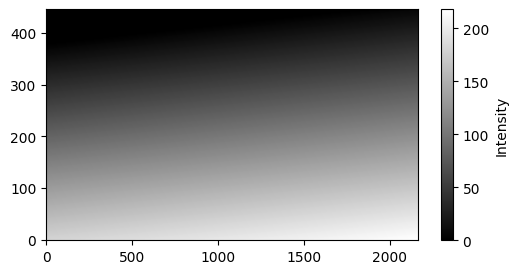

In [17]:
closest_planes_2D = pixel_y_clamped1[:, 10, :]

plt.figure(figsize= (2 * 3, 2 * 1.5 ))
plt.imshow(closest_planes_2D, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label="Intensity")
plt.show()

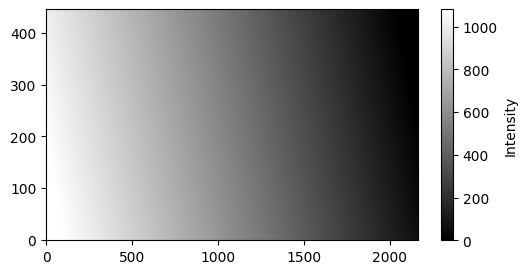

In [18]:
closest_planes_2D = pixel_x_clamped1[:, 50, :]

plt.figure(figsize= (2 * 3, 2 * 1.5 ))
plt.imshow(closest_planes_2D, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label="Intensity")
plt.show()

In [19]:
import numpy as np

plane_images = np.array(plane_images)  # Convert list to NumPy array
print(plane_images.shape)

# Generate grid indices for dimensions
grid_x, grid_y, grid_z = np.meshgrid(
    np.arange(first_closest_plane_indices.shape[0]),
    np.arange(first_closest_plane_indices.shape[1]),
    np.arange(first_closest_plane_indices.shape[2]),
    indexing="ij",
)

# Extract intensities for the two closest planes
intensities1 = plane_images[
    first_closest_plane_indices,
    pixel_x_clamped1,
    pixel_y_clamped1,
]
intensities2 = plane_images[
    second_closest_plane_indices,
    pixel_x_clamped2,
    pixel_y_clamped2,
]

print(intensities1.shape)
print(intensities2.shape)

(150, 1083, 223, 4)
(446, 300, 2166, 4)
(446, 300, 2166, 4)


In [20]:
# Delete buffers that are not used anymore.

del v1, v2, v_x1, v_y1, v_x2, v_y2, pixel_x_centered1, pixel_x_centered2, pixel_y_centered1, pixel_y_centered2, pixel_x1, pixel_y1, pixel_x2, pixel_y2, x_vectors1, x_vectors2, y_vectors1, y_vectors2, origins1, origins2

import gc
gc.collect()

10060

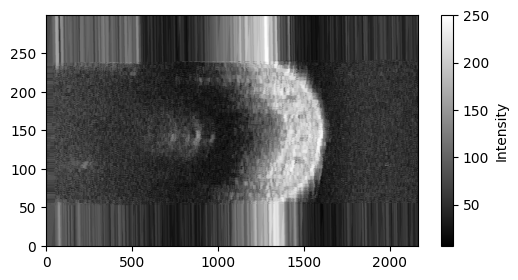

In [21]:
closest_planes_2D = intensities2[100, :, :, 0]

plt.figure(figsize= (2 * 3, 2 * 1.5 ))
plt.imshow(closest_planes_2D, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label="Intensity")
plt.show()

In [22]:
# Calculate weights for interpolation
weight1 = 1 / best_val1 / (1 / best_val1 + 1 / best_val2)
weight2 = 1 / best_val2 / (1 / best_val1 + 1 / best_val2)

weight1_expanded = np.stack([weight1] * 4, axis=-1)
weight2_expanded = np.stack([weight2] * 4, axis=-1)

# Perform weighted interpolation
# interpolated_intensity = weight1 * intensities1 + weight2 * intensities2
interpolated_intensity = weight1_expanded * intensities1 + weight2_expanded * intensities2
print(interpolated_intensity.shape)

(446, 300, 2166, 4)


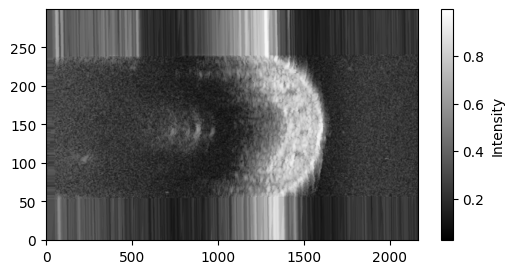

In [23]:
closest_planes_2D = interpolated_intensity[100, :, :, :]/256

plt.figure(figsize= (2 * 3, 2 * 1.5 ))
plt.imshow(closest_planes_2D, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label="Intensity")
plt.show()

In [24]:
# Distance for plane 0
distance_0 = (
    (query_points[..., 0] - plane_origins[0, 0]) * plane_normals[0, 0] +
    (query_points[..., 1] - plane_origins[0, 1]) * plane_normals[0, 1] +
    (query_points[..., 2] - plane_origins[0, 2]) * plane_normals[0, 2]
)

# Distance for plane -1 (the last plane)
distance_last = (
    (query_points[..., 0] - plane_origins[-1, 0]) * plane_normals[-1, 0] +
    (query_points[..., 1] - plane_origins[-1, 1]) * plane_normals[-1, 1] +
    (query_points[..., 2] - plane_origins[-1, 2]) * plane_normals[-1, 2]
)

# Mask for determining valid pixels
valid = (distance_0 > 0) & (distance_last < 0)
print("valid shape:", valid.shape)

valid_expanded = np.stack([valid] * 4, axis=-1)

# Generate masked_intensity
# masked_intensity = np.where(valid, interpolated_intensity, 0)
masked_intensity = np.where(valid_expanded, interpolated_intensity, 0)

valid shape: (446, 300, 2166)


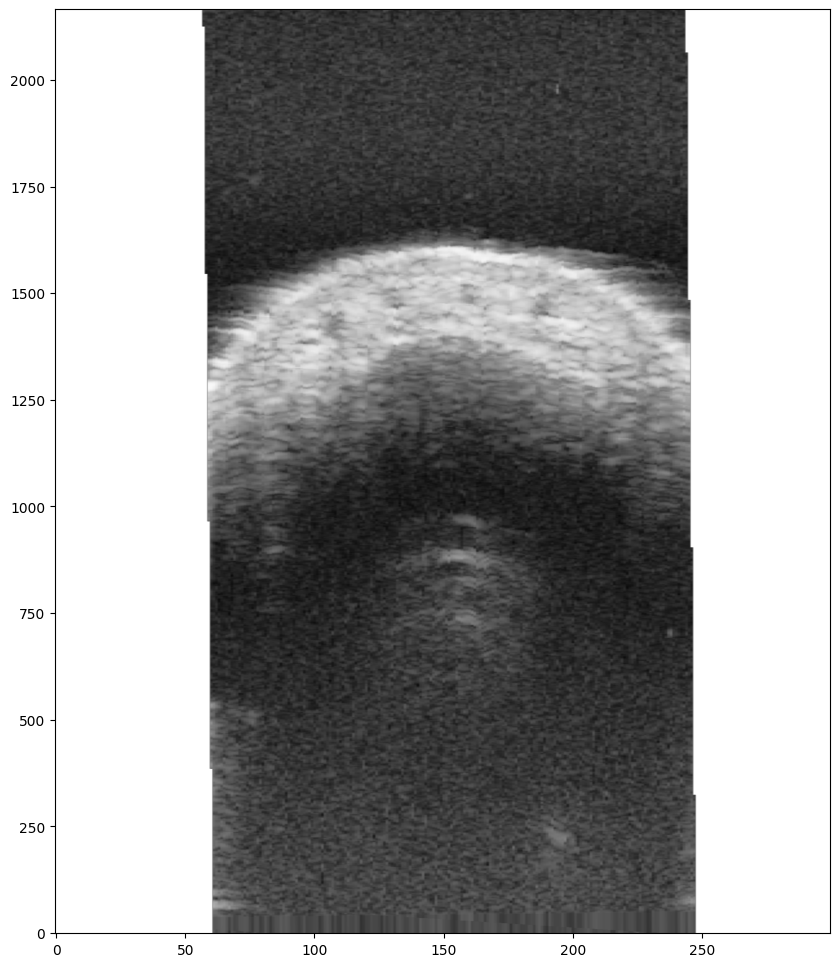

In [28]:
closest_planes_2D = np.rot90(masked_intensity[100, :, :, :]/256, k = -1)

plt.figure(figsize= (4 * 2.5 * 300/300, 4 * 3.0 * 2166 / 2166))
plt.imshow(closest_planes_2D, cmap='gray', origin='lower', aspect='auto')
# plt.colorbar(label="Intensity")
plt.show()

In [30]:
# np.save('20250215_arc_BScan_one.npy', masked_intensity[:, :, :, 0])
np.save('/content/drive/MyDrive/dataset/20250215_linear_BScan_one.npy', masked_intensity[:, :, :, 0])

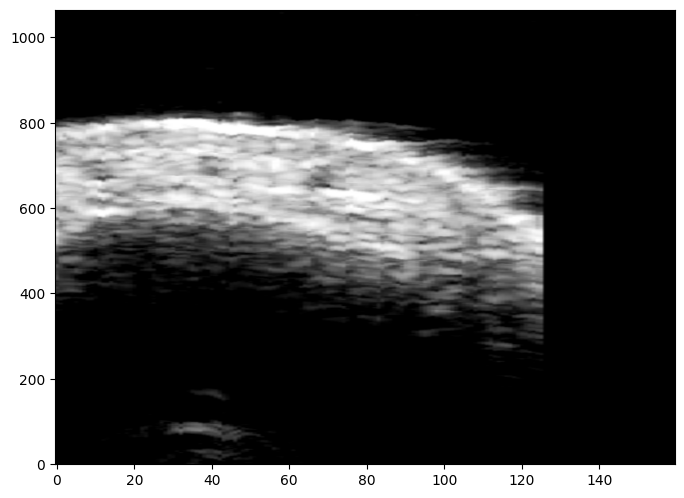

In [27]:
closest_planes_2D = np.rot90(masked_intensity[100, 20:180, 800:-300, 0], k = -1)

plt.figure(figsize= (4 * 2.5 * 160/200, 4 * 3.0 * 1066 / 2166))
plt.imshow(closest_planes_2D, cmap='gray', origin='lower', aspect='auto', vmin = 80, vmax = 230)
# plt.colorbar(label="Intensity")
plt.show()